# **Mini-Projet : Alternating Least Squares (ALS) pour les Systèmes de Recommandation**

**Auteur :** Mohamed LKHALIDI / Ahmed BOUBA 
**Date :** Novembre 2025  
**Contexte :** Master Intelligent Systems - Moulay Ismail University

## **1. Installation des dépendances et importation des bibliothèques**
Cette cellule installe la bibliothèque `implicit` (optimisée pour les recommandations) et importe toutes les bibliothèques nécessaires au projet :
- `numpy` et `pandas` pour la manipulation des données
- `scipy.sparse` pour les matrices creuses
- `matplotlib` pour les visualisations
- `sklearn` pour les métriques d'évaluation
- `implicit` pour l'implémentation ALS
- Et d'autres utilitaires (gestion du temps, warnings, etc.)

In [1]:
!pip install implicit
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, coo_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import time
import warnings
import os
import kagglehub
import implicit
import math
from collections import defaultdict
from sklearn.decomposition import PCA
import matplotlib.cm as cm
!pip install scikit-surprise
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 78.7 MB/s eta 0:00:00:00:0100:01


## Téléchargement du dataset MovieLens et Chargement des données
Cette cellule télécharge le dataset MovieLens via l'API Kaggle et affiche la structure des fichiers disponibles :
- `users.dat` : informations sur les utilisateurs
- `ratings.dat` : les notes attribuées aux films
- `movies.dat` : métadonnées des films

In [2]:
path = kagglehub.dataset_download("sherinclaudia/movielens")
print("Path to dataset files:", path)

print(f"Fichiers dans le répertoire: {os.listdir(path)}")
print(f"Chemin des données: {path}")

movies = pd.read_csv(os.path.join(path, 'movies.dat'), sep="::", engine="python", names=["MovieID", "Title", "Genres"], encoding="latin1")
ratings = pd.read_csv(os.path.join(path, 'ratings.dat'), sep="::", engine="python", names=["UserID", "MovieID", "Rating", "Timestamp"], encoding="latin1", usecols=["UserID", "MovieID", "Rating"])
users = pd.read_csv(os.path.join(path, 'users.dat'), sep="::", engine="python", names=["UserID", "Gender", "Age", "Occupation", "Zip-code"], encoding="latin1")

Path to dataset files: /kaggle/input/movielens
Fichiers dans le répertoire: ['users.dat', 'ratings.dat', 'movies.dat']
Chemin des données: /kaggle/input/movielens


## Exploration des données - Aperçu des notes
Affichage des 5 premières entrées du dataframe des notes pour comprendre la structure des données :
- UserID : identifiant unique de l'utilisateur
- MovieID : identifiant unique du film
- Rating : note attribuée (de 1 à 5)

In [3]:
# movies.head()
ratings.head()
# users.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


## Analyse de la structure du dataset
Calcul des dimensions clés du dataset et de sa sparsité :
- Nombre d'utilisateurs, de films et de notes totales
- Calcul de la densité (pourcentage de cellules remplies)
- La sparsité élevée (>95%) est typique des systèmes de recommandation

In [4]:
# Dimensions utilisateur × item
num_users = ratings['UserID'].nunique()
num_items = ratings['MovieID'].nunique()
num_ratings = len(ratings)

# Densité et sparsité
density = num_ratings / (num_users * num_items)
sparsity = 1 - density

print(f"Nombre d'utilisateurs : {num_users}")
print(f"Nombre de films : {num_items}")
print(f"Nombre de notes : {num_ratings}")
print(f"Densité : {density*100:.4f}%")
print(f"Sparsité : {sparsity*100:.4f}%")

Nombre d'utilisateurs : 6040
Nombre de films : 3706
Nombre de notes : 1000209
Densité : 4.4684%
Sparsité : 95.5316%


## Analyse des notes d'un utilisateur spécifique
Exemple détaillé des films notés par l'utilisateur 1 :
- Fusion avec les titres de films pour plus de lisibilité
- Tri par note décroissante
- Affichage des 10 meilleures notes

In [5]:
user_id = 1
user_ratings = ratings[ratings['UserID'] == user_id]
user_ratings = user_ratings.merge(movies[['MovieID', 'Title']], on='MovieID')

user_ratings = user_ratings.sort_values(by='Rating', ascending=False)
print(f"L'utilisateur {user_id} a noté {len(user_ratings)} films :")
display(user_ratings.head(10))  # top 10

L'utilisateur 1 a noté 53 films :


,UserID,MovieID,Rating,Title
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975)
4,1,2355,5,"Bug's Life, A (1998)"
10,1,595,5,Beauty and the Beast (1991)
7,1,2804,5,"Christmas Story, A (1983)"
6,1,1287,5,Ben-Hur (1959)
18,1,3105,5,Awakenings (1990)
14,1,1035,5,"Sound of Music, The (1965)"
40,1,1,5,Toy Story (1995)
41,1,1961,5,Rain Man (1988)
36,1,1836,5,"Last Days of Disco, The (1998)"


## Distribution de l'activité des utilisateurs
Visualisation du nombre de films notés par utilisateur :
- Histogramme montrant la distribution d'activité
- La plupart des utilisateurs notent peu de films
- Quelques utilisateurs très actifs (queue de distribution)

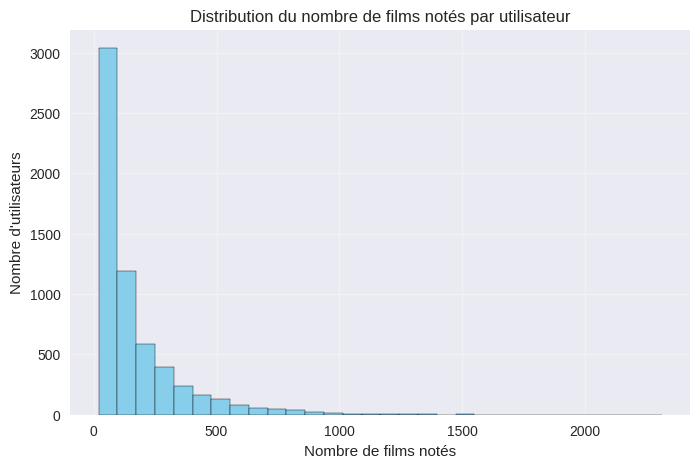

In [6]:
user_activity = ratings.groupby('UserID')['MovieID'].count()

plt.figure(figsize=(8,5), facecolor='none')
plt.hist(user_activity, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Nombre de films notés")
plt.ylabel("Nombre d'utilisateurs")
plt.title("Distribution du nombre de films notés par utilisateur")
plt.grid(alpha=0.3)
plt.show()

## Création de la matrice utilisateur-item
Construction de la matrice sparse des notes avec :
- Normalisation des notes entre 0 et 1
- Mapping des IDs utilisateurs et films vers des indices consécutifs
- Création d'une matrice CSR (Compressed Sparse Row) optimisée

In [7]:
def create_rating_matrix(ratings, normalize=True):
    """Crée une matrice sparse des ratings avec mapping d'IDs et option de normalisation"""
    
    # Étape 1 : Normalisation des ratings
    if normalize:
        min_rating = ratings['Rating'].min()
        max_rating = ratings['Rating'].max()
        ratings['Rating_norm'] = (ratings['Rating'] - min_rating) / (max_rating - min_rating)
        ratings_val = ratings['Rating_norm'].values
        print(f"Ratings normalisés entre 0 et 1 (min={min_rating}, max={max_rating})")
    else:
        ratings_val = ratings['Rating'].values
    
    # Étape 2 : Mapping des IDs vers des index consécutifs
    user_map = {u: i for i, u in enumerate(ratings['UserID'].unique())}
    item_map = {m: i for i, m in enumerate(ratings['MovieID'].unique())}
    
    user_indices = ratings['UserID'].map(user_map)
    item_indices = ratings['MovieID'].map(item_map)

    # Étape 3 : Construction de la matrice sparse
    n_users = len(user_map)
    n_items = len(item_map)
    
    rating_matrix = csr_matrix((ratings_val, (user_indices, item_indices)), shape=(n_users, n_items))
    
    return rating_matrix, user_map, item_map, n_users, n_items, (min_rating, max_rating)


# utilisation
rating_matrix, user_map, item_map, n_users, n_items, scale = create_rating_matrix(ratings, normalize=True)

print(f"Dimensions de la matrice: {rating_matrix.shape[0]} utilisateurs × {rating_matrix.shape[1]} films")
print(f"Nombre total de ratings: {rating_matrix.nnz}")
print("Matrice créée avec succès !")

Ratings normalisés entre 0 et 1 (min=1, max=5)
Dimensions de la matrice: 6040 utilisateurs × 3706 films
Nombre total de ratings: 1000209
Matrice créée avec succès !


## Vérification de la matrice créée
Affichage d'un extrait de la matrice (10 premiers utilisateurs × 20 premiers films) pour visualiser :
- Les notes normalisées (0.0 à 1.0)
- La structure sparse (beaucoup de zéros)
- La distribution des notes

In [8]:
print(rating_matrix[:10, :20].toarray())

[[1.   0.5  0.5  0.75 1.   0.5  1.   1.   0.75 0.75 1.   0.75 0.75 0.75
  1.   0.75 0.5  0.75 1.   0.75]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.75 0.  ]
 [0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.5  1.   0.   0.   0.   0.   0.75 0.   0.   0.   0.
  0.   0.   0.   0.   0.25 0.  ]
 [0.   0.   1.   1.   0.   0.   0.   0.   0.   0.   0.75 0.   0.   0.
  1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.75 0.  ]
 [0.   0.   0.   0.75 0.75 0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.75 0.75 1.   0.5  1.   1.   1.   1.   0.75 1.   1.
 

## Split des données en ensemble d'entraînement et de test
Implémentation d'un split personnalisé qui préserve la nature temporelle :
- Split par utilisateur (chaque utilisateur a des données dans train et test)
- Ratio de test fixé à 25%
- Gestion des utilisateurs avec très peu de notes

In [9]:
def train_test_split_sparse_per_user(matrix, test_ratio=0.25, random_state=42):
    
    np.random.seed(random_state)
    matrix = matrix.tocsr()

    n_users, n_items = matrix.shape
    train_rows, train_cols, train_data = [], [], []
    test_rows, test_cols, test_data = [], [], []

    for user in range(n_users):
        start, end = matrix.indptr[user], matrix.indptr[user + 1]
        user_items = matrix.indices[start:end]
        user_ratings = matrix.data[start:end]

        if len(user_items) == 0:
            continue

        # Si l'utilisateur a très peu de notes, tout en train
        if len(user_items) <= 2:
            train_rows.extend([user] * len(user_items))
            train_cols.extend(user_items)
            train_data.extend(user_ratings)
            continue

        # Sélection aléatoire d'un sous-ensemble pour test
        n_test = max(1, int(len(user_items) * test_ratio))
        indices = np.arange(len(user_items))
        np.random.shuffle(indices)

        test_idx = indices[:n_test]
        train_idx = indices[n_test:]

        # Train
        train_rows.extend([user] * len(train_idx))
        train_cols.extend(user_items[train_idx])
        train_data.extend(user_ratings[train_idx])

        # Test
        test_rows.extend([user] * len(test_idx))
        test_cols.extend(user_items[test_idx])
        test_data.extend(user_ratings[test_idx])

    train_matrix = csr_matrix((train_data, (train_rows, train_cols)), shape=(n_users, n_items))
    test_matrix = csr_matrix((test_data, (test_rows, test_cols)), shape=(n_users, n_items))

    print(f"Split terminé : {train_matrix.nnz:,} train / {test_matrix.nnz:,} test ratings")
    return train_matrix, test_matrix

## Application du split et préparation des données
Exécution du split et préparation des matrices pour l'algorithme ALS :
- Conversion en float32 pour optimiser la mémoire
- Vérification des dimensions finales
- Calcul des densités résultantes

In [10]:
train_matrix, test_matrix = train_test_split_sparse_per_user(rating_matrix, test_ratio=0.25)

# Préparer matrices pour ALS

train_matrix_implicit = train_matrix.astype(np.float32)
test_matrix_implicit = test_matrix.astype(np.float32)

print(f"\nMatrices prêtes pour ALS:")
print(f"   Train matrix: CSR (float32) pour implicit")
print(f"   Test matrix: CSR (float32) pour implicit")
print(f"   Dimensions: {n_users} users × {n_items} items")

Split terminé : 752,365 train / 247,844 test ratings

Matrices prêtes pour ALS:
   Train matrix: CSR (float32) pour implicit
   Test matrix: CSR (float32) pour implicit
   Dimensions: 6040 users × 3706 items


## Implémentation de l'algorithme ALS
Classe complète implémentant l'ALS avec :
- Initialisation des matrices utilisateurs et items
- Optimisation alternée avec régularisation
- Early stopping pour éviter le surapprentissage
- Métriques d'évaluation (RMSE, MAE)
- Fonctions de recommandation
- Visualisation de la progression

In [11]:
class ALSRecommender:
    def __init__(self, n_factors=15, lambda_reg=0.1, n_iterations=15, alpha=10, early_stopping_rounds=3, tolerance=1e-4, verbose=True):
        self.n_factors = n_factors
        self.lambda_reg = lambda_reg
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.early_stopping_rounds = early_stopping_rounds
        self.tolerance = tolerance
        self.verbose = verbose
        self.user_factors = None
        self.item_factors = None
        self.best_iteration = 0
        
    def fit(self, train_matrix, validation_matrix=None):
        """Entraîne le modèle ALS avec early stopping"""
        n_users, n_items = train_matrix.shape
        
        # Initialisation stable et positive
        self.user_factors = np.random.rand(n_users, self.n_factors) * 0.01
        self.item_factors = np.random.rand(n_items, self.n_factors) * 0.01

        I = np.eye(self.n_factors)
        lambda_I = self.lambda_reg * I
        
        train_coo = train_matrix.tocoo()
        
        self.train_rmse = []
        self.train_mae = []
        self.val_rmse = []
        self.val_mae = []
        self.best_rmse = float('inf')
        self.best_mae = float('inf')
        self.best_user_factors = None
        self.best_item_factors = None
        no_improvement_count = 0
        
        start_time = time.time()
        
        for iteration in range(self.n_iterations):
            iteration_start = time.time()

            # === Étape 1: Optimiser les utilisateurs ===
            for user_id in range(n_users):
                user_mask = (train_coo.row == user_id)
                if np.sum(user_mask) == 0:
                    continue
                    
                rated_items = train_coo.col[user_mask]
                ratings = train_coo.data[user_mask]
                
                M_u = self.item_factors[rated_items, :]
                r_u = ratings
                
                M_u_T = M_u.T
                A = M_u_T.dot(M_u) + lambda_I
                b = M_u_T.dot(r_u)
                self.user_factors[user_id, :] = np.linalg.solve(A, b)
            
            # === Étape 2: Optimiser les items ===
            for item_id in range(n_items):
                item_mask = (train_coo.col == item_id)
                if np.sum(item_mask) == 0:
                    continue
                    
                rated_users = train_coo.row[item_mask]
                ratings = train_coo.data[item_mask]
                
                U_i = self.user_factors[rated_users, :]
                r_i = ratings
                
                U_i_T = U_i.T
                A = U_i_T.dot(U_i) + lambda_I
                b = U_i_T.dot(r_i)
                self.item_factors[item_id, :] = np.linalg.solve(A, b)
            
            # Calcul des métriques
            train_rmse = self.calculate_rmse(train_matrix)
            train_mae = self.calculate_mae(train_matrix)
            self.train_rmse.append(train_rmse)
            self.train_mae.append(train_mae)
            
            if validation_matrix is not None:
                val_rmse = self.calculate_rmse(validation_matrix)
                val_mae = self.calculate_mae(validation_matrix)
                self.val_rmse.append(val_rmse)
                self.val_mae.append(val_mae)
                current_rmse = val_rmse
                current_mae = val_mae
            else:
                current_rmse = train_rmse
                current_mae = train_mae
            
            iteration_time = time.time() - iteration_start
            
            # Early stopping logic (basé sur RMSE)
            improvement = self.best_rmse - current_rmse
            if improvement > self.tolerance:
                self.best_rmse = current_rmse
                self.best_mae = current_mae
                self.best_user_factors = self.user_factors.copy()
                self.best_item_factors = self.item_factors.copy()
                self.best_iteration = iteration
                no_improvement_count = 0
                
                if self.verbose:
                    print(f"🌟 Meilleure performance à l'itération {iteration+1}: RMSE = {current_rmse:.4f}, MAE = {current_mae:.4f}")
            else:
                no_improvement_count += 1
                if self.verbose:
                    print(f"Pas d'amélioration depuis {no_improvement_count} itération(s)")
            
            # Affichage des résultats de l'itération
            if self.verbose:
                val_info = f" - RMSE Val: {val_rmse:.4f}, MAE Val: {val_mae:.4f}" if validation_matrix is not None else ""
                print(f"Itération {iteration+1}/{self.n_iterations} - RMSE Train: {train_rmse:.4f}, MAE Train: {train_mae:.4f}{val_info} - Temps: {iteration_time:.2f}s")
            
            # Vérification de l'early stopping
            if no_improvement_count >= self.early_stopping_rounds:
                if self.verbose:
                    print(f"Early stopping déclenché à l'itération {iteration+1}")
                    print(f"Meilleure itération: {self.best_iteration + 1} avec RMSE: {self.best_rmse:.4f}, MAE: {self.best_mae:.4f}")
                break
        
        # Restauration des meilleurs paramètres
        if self.best_user_factors is not None:
            self.user_factors = self.best_user_factors
            self.item_factors = self.best_item_factors
        
        total_time = time.time() - start_time
        if self.verbose:
            print(f"Entraînement terminé en {total_time:.2f}s")
            print(f"Meilleure performance: RMSE = {self.best_rmse:.4f}, MAE = {self.best_mae:.4f} à l'itération {self.best_iteration + 1}")
    
    def predict(self, user_id, item_id):
        if self.user_factors is None or self.item_factors is None:
            raise ValueError("Le modèle n'est pas encore entraîné. Appelez fit() d'abord.")
        
        prediction = self.user_factors[user_id, :].dot(self.item_factors[item_id, :].T)
        return np.clip(prediction, 0.0, 1.0)
    
    def calculate_rmse(self, matrix):
        predictions = []
        actuals = []
        matrix_coo = matrix.tocoo()
        
        # Calcul batch pour plus de performance
        user_ids = matrix_coo.row
        item_ids = matrix_coo.col
        ratings = matrix_coo.data
        
        # Prédictions vectorisées
        preds = np.sum(self.user_factors[user_ids] * self.item_factors[item_ids], axis=1)
        preds = np.clip(preds, 0.0, 1.0)
        
        return np.sqrt(np.mean((ratings - preds) ** 2))
    
    def calculate_mae(self, matrix):
        matrix_coo = matrix.tocoo()
        
        # Calcul batch pour plus de performance
        user_ids = matrix_coo.row
        item_ids = matrix_coo.col
        ratings = matrix_coo.data
        
        # Prédictions vectorisées
        preds = np.sum(self.user_factors[user_ids] * self.item_factors[item_ids], axis=1)
        preds = np.clip(preds, 0.0, 1.0)
        
        return np.mean(np.abs(ratings - preds))
    
    def recommend_for_user(self, user_id, n_recommendations=10, min_ratings=5, include_actual=False):

        if self.user_factors is None or self.item_factors is None:
            raise ValueError("Le modèle n'est pas encore entraîné. Appelez fit() d'abord.")
        
        user_ratings = train_matrix[user_id, :].toarray().flatten()
        rated_items = set(np.where(user_ratings > 0)[0])
        
        item_popularity = np.array(train_matrix.getnnz(axis=0)).flatten()
        
        predictions = []
        for item_id in range(self.item_factors.shape[0]):
            if item_id not in rated_items and item_popularity[item_id] >= min_ratings:
                pred_rating = self.predict(user_id, item_id)
                actual_rating = test_matrix[user_id, item_id] if include_actual else None
                predictions.append((item_id, pred_rating, actual_rating, item_popularity[item_id]))
        
        # Tri: note prédite (desc), puis popularité (desc)
        predictions.sort(key=lambda x: (-x[1], -x[3]))
        
        if include_actual:
            return [(item_id, pred_rating, actual_rating) for item_id, pred_rating, actual_rating, _ in predictions[:n_recommendations]]
        else:
            return [(item_id, pred_rating) for item_id, pred_rating, _, _ in predictions[:n_recommendations]]

    def plot_training_history(self):        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), facecolor='none')
        iterations = range(1, len(self.train_rmse) + 1)
        
        # Graphique RMSE
        ax1.plot(iterations, self.train_rmse, 'b-', label='Train RMSE', marker='o')
        if self.val_rmse:
            ax1.plot(iterations, self.val_rmse, 'r-', label='Validation RMSE', marker='s')
        ax1.axvline(x=self.best_iteration + 1, color='g', linestyle='--', 
                   label=f'Meilleure itération ({self.best_iteration + 1})')
        ax1.set_xlabel('Itérations')
        ax1.set_ylabel('RMSE')
        ax1.set_title('Historique RMSE - ALS')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Graphique MAE
        ax2.plot(iterations, self.train_mae, 'b-', label='Train MAE', marker='o')
        if self.val_mae:
            ax2.plot(iterations, self.val_mae, 'r-', label='Validation MAE', marker='s')
        ax2.axvline(x=self.best_iteration + 1, color='g', linestyle='--', 
                   label=f'Meilleure itération ({self.best_iteration + 1})')
        ax2.set_xlabel('Itérations')
        ax2.set_ylabel('MAE')
        ax2.set_title('Historique MAE - ALS')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_combined_training_history(self):        
        plt.figure(figsize=(12, 6), facecolor='none')
        iterations = range(1, len(self.train_rmse) + 1)
        
        # RMSE
        plt.plot(iterations, self.train_rmse, 'b-', label='Train RMSE', marker='o', alpha=0.7)
        if self.val_rmse:
            plt.plot(iterations, self.val_rmse, 'b--', label='Validation RMSE', marker='s', alpha=0.7)
        
        # MAE
        plt.plot(iterations, self.train_mae, 'r-', label='Train MAE', marker='o', alpha=0.7)
        if self.val_mae:
            plt.plot(iterations, self.val_mae, 'r--', label='Validation MAE', marker='s', alpha=0.7)
        
        plt.axvline(x=self.best_iteration + 1, color='g', linestyle='--', 
                   label=f'Meilleure itération ({self.best_iteration + 1})')
        
        plt.xlabel('Itérations')
        plt.ylabel('Erreur')
        plt.title('Historique d\'entraînement ALS - RMSE et MAE')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def denormalize(self, value, scale):
        min_r, max_r = scale
        return value * (max_r - min_r) + min_r

    def evaluate_test_set(self, test_matrix):
        test_rmse = self.calculate_rmse(test_matrix)
        test_mae = self.calculate_mae(test_matrix)
        return test_rmse, test_mae

print("ALS avec Early Stopping et MAE Ready..")

ALS avec Early Stopping et MAE Ready..


## Division des données en ensemble d'entraînement et de validation
Création d'un ensemble de validation à partir des données d'entraînement :
- 10% des données d'entraînement utilisées pour la validation
- Permutation aléatoire pour éviter les biais
- Conservation de la structure sparse

In [12]:
def split_train_val(train_matrix, val_ratio=0.1):
    """Divise les données d'entraînement en train et validation"""
    train_coo = train_matrix.tocoo()
    n_ratings = len(train_coo.data)
    
    # Mélange aléatoire des indices
    indices = np.random.permutation(n_ratings)
    val_size = int(n_ratings * val_ratio)
    
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]
    
    # Création des matrices train et validation
    train_data = coo_matrix(
        (train_coo.data[train_indices], 
         (train_coo.row[train_indices], train_coo.col[train_indices])),
        shape=train_matrix.shape
    ).tocsr()
    
    val_data = coo_matrix(
        (train_coo.data[val_indices], 
         (train_coo.row[val_indices], train_coo.col[val_indices])),
        shape=train_matrix.shape
    ).tocsr()
    
    return train_data, val_data
    
# Division des données
train_data_split, val_data_split = split_train_val(train_matrix, val_ratio=0.1)

print(f"Taille train: {train_data_split.nnz} ratings")
print(f"Taille validation: {val_data_split.nnz} ratings")

Taille train: 677129 ratings
Taille validation: 75236 ratings


## Configuration et entraînement du modèle ALS
Initialisation et entraînement du modèle avec les hyperparamètres optimaux :
- 10 facteurs latents
- Régularisation λ=1.1
- Early stopping après 5 itérations sans amélioration
- Affichage détaillé de la progression

In [13]:
BEST_N_FACTORS = 10
BEST_LAMBDA = 1.1
BEST_ITERATIONS = 30

print("\nIMPLÉMENTATION MANUELLE AVEC EARLY STOPPING :")
print(f"   - Facteurs latents: {BEST_N_FACTORS}")
print(f"   - Régularisation: {BEST_LAMBDA}")
print(f"   - Itérations max: {BEST_ITERATIONS}")
print(f"   - Early stopping: activé après 5 itérations sans amélioration")

manual_model = ALSRecommender(
    n_factors=BEST_N_FACTORS,
    lambda_reg=BEST_LAMBDA, 
    n_iterations=BEST_ITERATIONS,
    early_stopping_rounds=5,
    tolerance=1e-4,
    verbose=True
)

# Entraînement avec validation
print("\nDébut de l'entraînement avec Early Stopping...")
manual_model.fit(train_data_split, validation_matrix=val_data_split)


IMPLÉMENTATION MANUELLE AVEC EARLY STOPPING :
   - Facteurs latents: 10
   - Régularisation: 1.1
   - Itérations max: 30
   - Early stopping: activé après 5 itérations sans amélioration

Début de l'entraînement avec Early Stopping...
🌟 Meilleure performance à l'itération 1: RMSE = 0.4321, MAE = 0.3548
Itération 1/30 - RMSE Train: 0.4258, MAE Train: 0.3491 - RMSE Val: 0.4321, MAE Val: 0.3548 - Temps: 11.17s
🌟 Meilleure performance à l'itération 2: RMSE = 0.2315, MAE = 0.1813
Itération 2/30 - RMSE Train: 0.2096, MAE Train: 0.1652 - RMSE Val: 0.2315, MAE Val: 0.1813 - Temps: 11.16s
🌟 Meilleure performance à l'itération 3: RMSE = 0.2222, MAE = 0.1737
Itération 3/30 - RMSE Train: 0.1981, MAE Train: 0.1558 - RMSE Val: 0.2222, MAE Val: 0.1737 - Temps: 11.28s
🌟 Meilleure performance à l'itération 4: RMSE = 0.2190, MAE = 0.1709
Itération 4/30 - RMSE Train: 0.1939, MAE Train: 0.1523 - RMSE Val: 0.2190, MAE Val: 0.1709 - Temps: 11.19s
🌟 Meilleure performance à l'itération 5: RMSE = 0.2177, MAE =

## Analyse des résultats et visualisation
Synthèse complète des performances du modèle :
- Comparaison entraînement/validation/test
- Historique détaillé des itérations
- Visualisations des courbes d'apprentissage
- Analyse du gain de temps avec l'early stopping


 RÉSULTATS FINAUX - Modèle Manuel avec Early Stopping:
   Meilleure itération: 18/30
   RMSE Validation: 0.2160
   RMSE Test final: 0.2160
   MAE Test final: 0.1683
   Gain de temps: 40.0%

HISTORIQUE D'ENTRAÎNEMENT:
   Itération  1: Train RMSE = 0.4258, Val RMSE = 0.4321
   Itération  2: Train RMSE = 0.2096, Val RMSE = 0.2315
   Itération  3: Train RMSE = 0.1981, Val RMSE = 0.2222
   Itération  4: Train RMSE = 0.1939, Val RMSE = 0.2190
   Itération  5: Train RMSE = 0.1919, Val RMSE = 0.2177
   Itération  6: Train RMSE = 0.1909, Val RMSE = 0.2171
   Itération  7: Train RMSE = 0.1903, Val RMSE = 0.2168
   Itération  8: Train RMSE = 0.1899, Val RMSE = 0.2166
   Itération  9: Train RMSE = 0.1896, Val RMSE = 0.2164
   Itération 10: Train RMSE = 0.1894, Val RMSE = 0.2164
   Itération 11: Train RMSE = 0.1892, Val RMSE = 0.2163
   Itération 12: Train RMSE = 0.1891, Val RMSE = 0.2162
   Itération 13: Train RMSE = 0.1891, Val RMSE = 0.2162
   Itération 14: Train RMSE = 0.1890, Val RMSE = 0.216

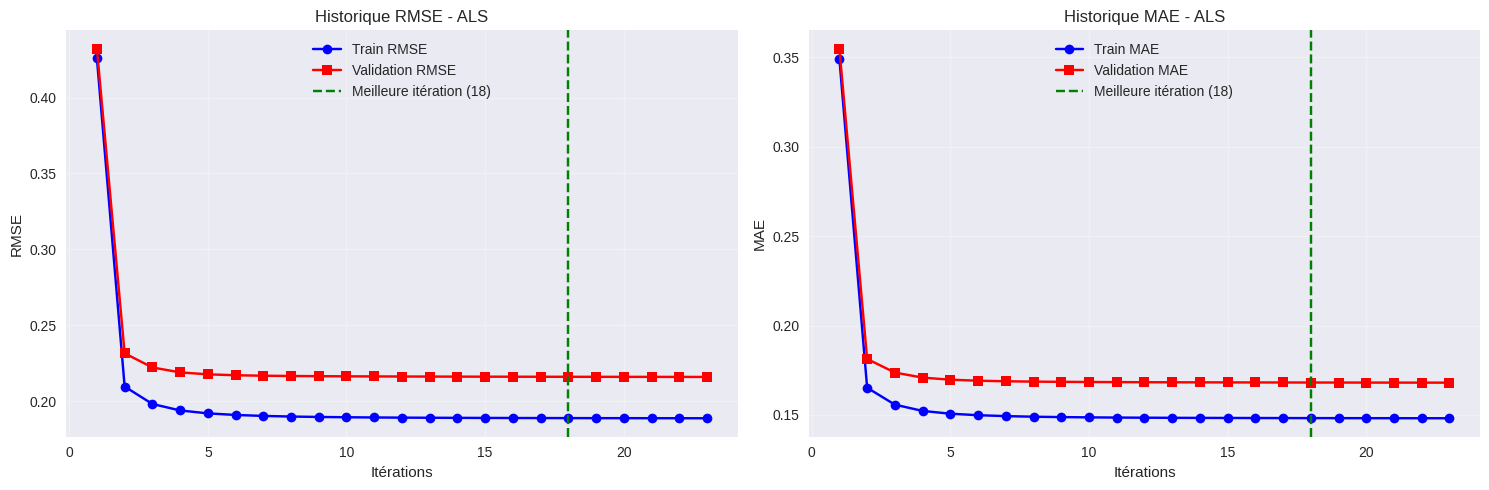


COMPARAISON DES MÉTRIQUES:
   Modèle          RMSE       MAE       
   --------------- ---------- ----------
   ALS             0.2160     0.1683    


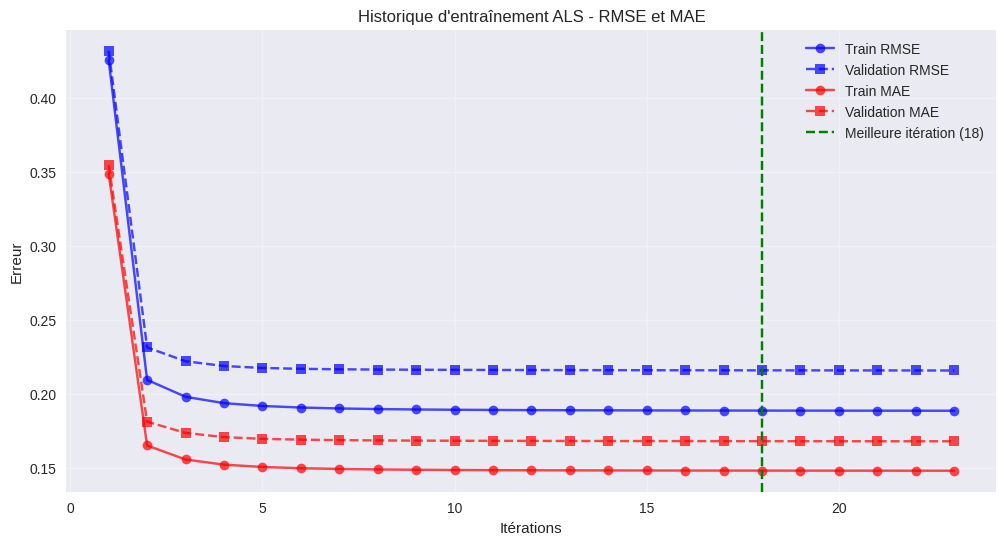

In [14]:
print(f"\n RÉSULTATS FINAUX - Modèle Manuel avec Early Stopping:")
print(f"   Meilleure itération: {manual_model.best_iteration + 1}/{BEST_ITERATIONS}")
print(f"   RMSE Validation: {manual_model.best_rmse:.4f}")
print(f"   RMSE Test final: {manual_model.calculate_rmse(test_matrix):.4f}")
print(f"   MAE Test final: {manual_model.calculate_mae(test_matrix):.4f}")
print(f"   Gain de temps: {((BEST_ITERATIONS - (manual_model.best_iteration + 1)) / BEST_ITERATIONS * 100):.1f}%")

# Affichage de l'historique d'entraînement
print(f"\nHISTORIQUE D'ENTRAÎNEMENT:")
for i, (train_rmse, val_rmse) in enumerate(zip(manual_model.train_rmse, manual_model.val_rmse)):
    marker = " 🌟" if i == manual_model.best_iteration else ""
    print(f"   Itération {i+1:2d}: Train RMSE = {train_rmse:.4f}, Val RMSE = {val_rmse:.4f}{marker}")

# Visualisation de l'historique
manual_model.plot_training_history()

# Évaluation sur le test set avec les deux métriques
test_rmse, test_mae = manual_model.evaluate_test_set(test_matrix)
print(f"\nCOMPARAISON DES MÉTRIQUES:")
print(f"   {'Modèle':<15} {'RMSE':<10} {'MAE':<10}")
print(f"   {'-'*15} {'-'*10} {'-'*10}")
print(f"   {'ALS':<15} {test_rmse:<10.4f} {test_mae:<10.4f}")

# Affichage de l'historique combiné
manual_model.plot_combined_training_history()

## Évaluation des performances et conversion des prédictions

Dans cette cellule, nous avons implémenté :

### 1. Métriques d'évaluation avancées
- **NDCG** : Mesure la qualité du classement des recommandations en donnant plus de poids aux items pertinents placés en haut de la liste
- **Précision/Recall/F1** : Évaluent la pertinence des recommandations par rapport aux vraies préférences des utilisateurs
- **Coverage** : Mesure la diversité des recommandations (pourcentage du catalogue recommandé)

### 2. Adaptation aux données normalisées
- Conversion des notes normalisées (0-1) en scores de pertinence binaires
- Utilisation d'un seuil (0.7 = 3.5/5) pour déterminer si une note est "pertinente"
- Gestion robuste des utilisateurs sans données de test

### 3. Dénormalisation des prédictions
- Reconversion des prédictions normalisées (0-1) vers l'échelle originale (1-5)
- Deux versions : basique et avancée avec détection intelligente des absences de notes
- Permet d'interpréter les résultats dans l'échelle compréhensible par les utilisateurs

Ces fonctions permettent d'évaluer objectivement la qualité de notre système de recommandation ALS.

In [15]:
def calculate_ndcg(recommended_items, test_matrix, user_id, k, threshold=0.7):
    """Calcule le NDCG pour données normalisées (0-1)"""
    dcg = 0.0
    relevance_scores = []
    
    # Récupérer TOUTES les notes de l'utilisateur dans le test set
    user_test_data = test_matrix[user_id].tocoo()
    user_ratings_dict = {item_id: rating for item_id, rating in zip(user_test_data.col, user_test_data.data)}
    
    for i, item_id in enumerate(recommended_items[:k]):
        # Utiliser le dictionnaire pour récupérer la vraie note
        true_rating = user_ratings_dict.get(item_id, 0)
        
        # Convertir en score de pertinence (0 si < threshold, note sinon)
        # Ajusté pour l'échelle 0-1 (0.7 ≈ 3.5/5)
        relevance = true_rating if true_rating >= threshold else 0
        relevance_scores.append(relevance)
        
        if relevance > 0:
            dcg += relevance/math.log2(i + 2)
    
    # IDCG : trier les notes par ordre décroissant
    ideal_relevance = sorted(relevance_scores, reverse=True)
    idcg = sum(rel / math.log2(i + 2) for i, rel in enumerate(ideal_relevance) if rel > 0)
    
    return dcg / idcg if idcg > 0 else 0.0


def calculate_metrics(model, train_matrix, test_matrix, k=30, threshold=0.7):
    n_users, n_items = train_matrix.shape
    precision_list, recall_list, f1_list, ndcg_list = [], [], [], []
    all_recommended_items = set()
    
    for user_id in range(n_users):
        user_test_ratings = test_matrix[user_id].tocoo()
        relevant_items = set()
        
        # Identifier les items pertinents (note >= threshold)
        for idx in range(len(user_test_ratings.data)):
            if user_test_ratings.data[idx] >= threshold:
                relevant_items.add(user_test_ratings.col[idx])
        
        if not relevant_items:
            continue
        
        try:
            # Obtenir les recommandations
            recs = model.recommend_for_user(user_id, n_recommendations=k, min_ratings=5)  # Réduit min_ratings
            recommended_items = [item_id for item_id, _ in recs]
            
            all_recommended_items.update(recommended_items)
            
            # Calcul des métriques de base
            hits = len(set(recommended_items) & relevant_items)
            precision = hits / k if k > 0 else 0
            recall = hits / len(relevant_items) if len(relevant_items) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
            
            # NDCG
            ndcg = calculate_ndcg(recommended_items, test_matrix, user_id, k, threshold)
            ndcg_list.append(ndcg)
            
        except Exception as e:
            continue
    
    # Statistiques finales
    users_evaluated = len(precision_list)
    
    return {
        "Precision@k": np.mean(precision_list) if precision_list else 0,
        "Recall@k": np.mean(recall_list) if recall_list else 0,
        "F1@k": np.mean(f1_list) if f1_list else 0,
        "NDCG@k": np.mean(ndcg_list) if ndcg_list else 0,
        "Coverage@k": len(all_recommended_items) / n_items if n_items > 0 else 0,
        "Users_evaluated": users_evaluated,
        "Total_users": n_users
    }

def denormalize_predictions(recommendations, scale, epsilon=1e-6):
    min_rating, max_rating = scale
    denormalized_recs = []
    
    # Calcul du seuil : les notes très proches de 0 sont probablement des absences
    threshold = 0.1 * (max_rating - min_rating) / (max_rating - min_rating)  # 10% de l'échelle normalisée
    
    for item_id, pred, actual_rating_normalized in recommendations:
        # Dénormalisation de la prédiction
        denorm_pred = pred * (max_rating - min_rating) + min_rating
        
        # Détection intelligente des absences
        if actual_rating_normalized is None or actual_rating_normalized <= threshold:
            denorm_actual = None  # Absence de note
        else:
            denorm_actual = actual_rating_normalized * (max_rating - min_rating) + min_rating
        
        denormalized_recs.append((item_id, denorm_pred, denorm_actual))
    
    return denormalized_recs

## Évaluation Complète du Modèle

### Analyse Multi-Critères avec Différentes Profondeurs de Recommandation

Cette fonction effectue une évaluation exhaustive du modèle de recommandation en testant différentes tailles de liste de recommandations (k=5, 10, 20, 30). Pour chaque valeur de k, elle calcule :

- **Precision@k** : Exactitude des recommandations dans le top-k
- **Recall@k** : Capacité à retrouver tous les items pertinents  
- **F1@k** : Équilibre entre précision et rappel
- **NDCG@k** : Qualité du classement avec pénalité de position
- **Coverage@k** : Diversité des items recommandés
- **Utilisateurs évalués** : Portée de l'évaluation

Le seuil de pertinence est fixé à 0.7 (équivalent à 3.5/5 étoiles) pour les données normalisées.

In [16]:
# Fonction D'Évaluation
def evaluate_model_comprehensive(model, train_matrix, test_matrix, scale, k_values=[5, 10, 20, 30]):
    """Évaluation complète avec différentes valeurs de k"""
    results = {}
    
    for k in k_values:
        print(f"\n######## Évaluation avec k={k}")
        
        # Seuil adapté pour données normalisées (0.7 ≈ 3.5/5)
        threshold = 0.7
        
        metrics = calculate_metrics(
            model, train_matrix, test_matrix, 
            k=k, threshold=threshold
        )
        
        results[f"k={k}"] = metrics
        
        print(f"   Precision@{k}: {metrics['Precision@k']:.4f}")
        print(f"   Recall@{k}: {metrics['Recall@k']:.4f}")
        print(f"   F1@{k}: {metrics['F1@k']:.4f}")
        print(f"   NDCG@{k}: {metrics['NDCG@k']:.4f}")
        print(f"   Coverage@{k}: {metrics['Coverage@k']:.4f}")
        print(f"   Utilisateurs évalués: {metrics['Users_evaluated']}/{metrics['Total_users']}")
    
    return results

# Évaluation du modèle
print("ÉVALUATION DU MODÈLE")
results = evaluate_model_comprehensive(manual_model, train_data_split, test_matrix, scale)

ÉVALUATION DU MODÈLE

######## Évaluation avec k=5
   Precision@5: 0.1694
   Recall@5: 0.0442
   F1@5: 0.0597
   NDCG@5: 0.3527
   Coverage@5: 0.1751
   Utilisateurs évalués: 6026/6040

######## Évaluation avec k=10
   Precision@10: 0.1417
   Recall@10: 0.0749
   F1@10: 0.0794
   NDCG@10: 0.3870
   Coverage@10: 0.2393
   Utilisateurs évalués: 6026/6040

######## Évaluation avec k=20
   Precision@20: 0.1153
   Recall@20: 0.1183
   F1@20: 0.0937
   NDCG@20: 0.4049
   Coverage@20: 0.3152
   Utilisateurs évalués: 6026/6040

######## Évaluation avec k=30
   Precision@30: 0.1015
   Recall@30: 0.1550
   F1@30: 0.0992
   NDCG@30: 0.4128
   Coverage@30: 0.3586
   Utilisateurs évalués: 6026/6040


## Exemple de Recommandations Personnalisées

### Analyse Détaillée pour un Utilisateur Spécifique

Cette section présente un exemple concret de recommandations générées par notre modèle ALS pour un utilisateur particulier (ID: 270). Le processus inclut :

- **Récupération des recommandations** : Obtention du top-10 des films prédits
- **Dénormalisation** : Conversion des scores (0-1) vers l'échelle 1-5 étoiles
- **Analyse comparative** : Comparaison prédictions vs notes réelles lorsque disponibles
- **Calcul d'erreur** : Écart absolu entre prédiction et réalité pour les films déjà notés

Le tableau résultant montre pour chaque recommandation :
- Son rang dans la liste
- L'identifiant du film
- La note réelle (si l'utilisateur l'a noté)
- La note prédite par le modèle
- L'erreur de prédiction


In [17]:
# Exemple de recommandations
user_id = 270 #326

# Obtenir les recommandations normalisées
recs_normalized = manual_model.recommend_for_user(
    user_id, 
    n_recommendations=10, 
    min_ratings=5, 
    include_actual=True
)

# Dénormaliser avec gestion des absences
recs_denormalized = denormalize_predictions(recs_normalized, scale)

# Préparer la liste pour le DataFrame
table_data = []
for i, (item_id, pred_rating, actual_rating) in enumerate(recs_denormalized):
    if actual_rating is not None:
        error = abs(pred_rating - actual_rating)
        table_data.append({
            "Rank": i + 1,
            "Item ID": item_id,
            "Actual Rating": actual_rating,
            "Predicted Rating": pred_rating,
            "Error": error,
        })
    else:
        table_data.append({
            "Rank": i + 1,
            "Item ID": item_id,
            "Actual Rating": None,
            "Predicted Rating": pred_rating,
            "Error": None,
        })

# Créer le DataFrame
df_recommendations = pd.DataFrame(table_data)

# Afficher le tableau
print(f"\nRecommandations pour l'utilisateur {user_id}:")
print("="*50)
display(df_recommendations)


Recommandations pour l'utilisateur 270:


,Rank,Item ID,Actual Rating,Predicted Rating,Error
0,1,64,5.0,5.000000,0.0
1,2,167,4.0,5.000000,1.0
2,3,259,NaN,5.000000,NaN
3,4,505,5.0,5.000000,0.0
4,5,52,NaN,5.000000,NaN
5,6,29,5.0,5.000000,0.0
6,7,506,NaN,5.000000,NaN
7,8,500,NaN,5.000000,NaN
8,9,1467,NaN,4.987584,NaN
9,10,377,NaN,4.957685,NaN


## Visualisation des Facteurs Latents

### Analyse en Composantes Principales (PCA) des Représentations d'Items

Cette section explore l'espace latent appris par le modèle ALS en visualisant les facteurs latents des films dans un plan 2D via l'ACP :

- **Réduction de dimension** : Passage des 10 facteurs latents à 2 dimensions principales
- **Coloration par genre** : Chaque point représente un film, coloré selon son genre principal
- **Échantillonnage intelligent** : Affichage de 1000 films pour une visualisation claire
- **Interprétation géométrique** : Les films proches dans l'espace ont des caractéristiques similaires

La variance expliquée indique dans quelle mesure les 2 premières composantes capturent l'information des facteurs originaux, révélant la structure sous-jacente des préférences utilisateurs.

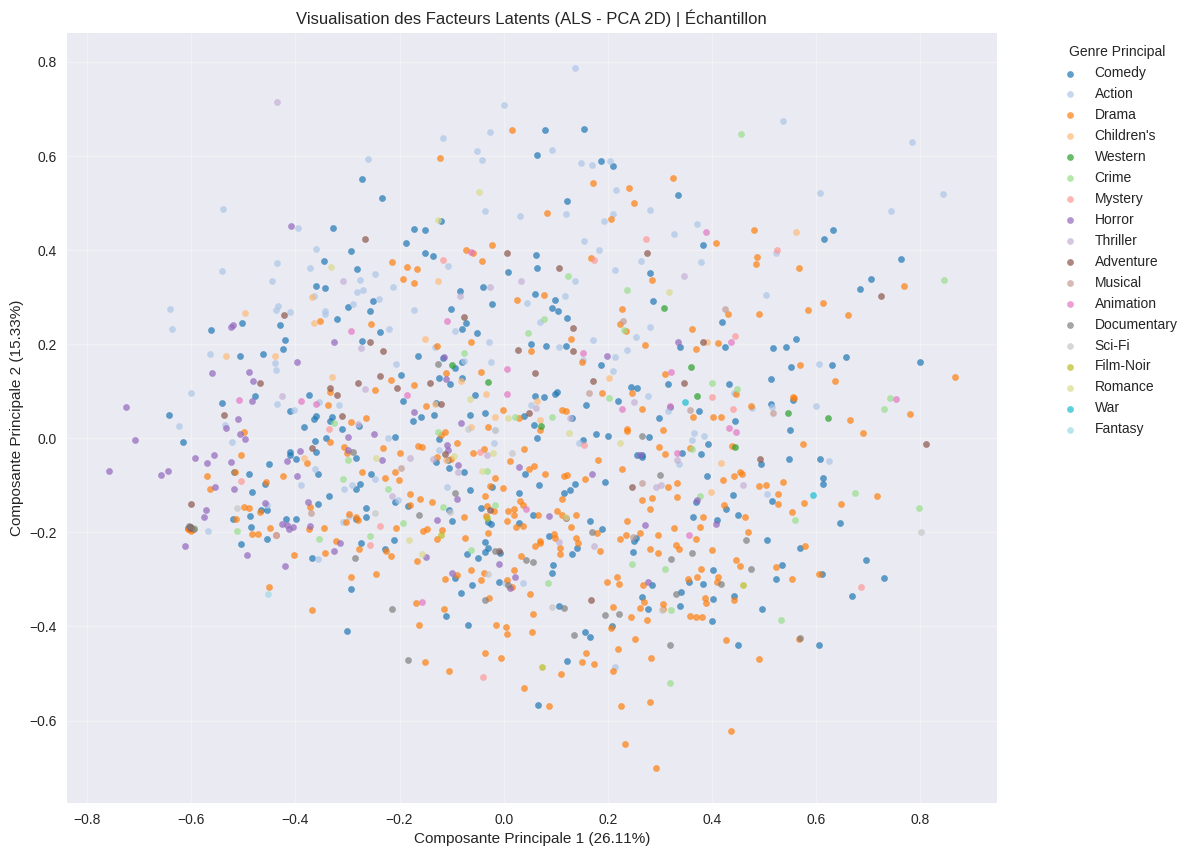

Variance totale expliquée par PC1 et PC2: 41.45%


In [18]:
# Extraire les facteurs latents des items
item_factors = manual_model.item_factors

# Appliquer PCA pour réduire à 2 dimensions
pca = PCA(n_components=2, random_state=42)
item_factors_2d = pca.fit_transform(item_factors)

# Créer un DataFrame avec les résultats PCA
factors_df = pd.DataFrame(item_factors_2d, columns=['PC1', 'PC2'])
factors_df.index.name = 'Item_Internal_Index'

# Créer le mapping inverse pour relier l'index interne au MovieID
item_map_inv = {v: k for k, v in item_map.items()}
factors_df['MovieID'] = factors_df.index.map(item_map_inv)

# Fusionner avec le DataFrame 'movies' pour obtenir les titres et genres
# On crée la colonne de Genre Principal pour la couleur du graphique
movies['Main_Genre'] = movies['Genres'].apply(lambda x: x.split('|')[0])
factors_df = factors_df.merge(movies[['MovieID', 'Title', 'Main_Genre']], on='MovieID', how='left')

# Échantillonnage pour la visualisation (sinon trop de points)
SAMPLE_SIZE = 1000
if len(factors_df) > SAMPLE_SIZE:
    sample_df = factors_df.sample(n=SAMPLE_SIZE, random_state=42)
else:
    sample_df = factors_df

# Visualisation
plt.figure(figsize=(12, 10), facecolor='none')

# Définir une palette de couleurs basée sur le genre
genres = sample_df['Main_Genre'].unique()
colors = cm.get_cmap('tab20', len(genres))
genre_to_color = {genre: colors(i) for i, genre in enumerate(genres)}

for genre in genres:
    subset = sample_df[sample_df['Main_Genre'] == genre]
    plt.scatter(subset['PC1'], subset['PC2'],
                s=20, alpha=0.7,
                color=genre_to_color[genre],
                label=genre)

# Ajouter la variance expliquée aux étiquettes des axes
explained_variance = pca.explained_variance_ratio_
plt.title('Visualisation des Facteurs Latents (ALS - PCA 2D) | Échantillon')
plt.xlabel(f'Composante Principale 1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'Composante Principale 2 ({explained_variance[1]*100:.2f}%)')
plt.legend(title='Genre Principal', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# Interprétation
print(f"Variance totale expliquée par PC1 et PC2: {(explained_variance[0] + explained_variance[1])*100:.2f}%")

# **Comparaison avec SVD via la Bibliothèque Surprise**

### Préparation des Données pour Surprise

Cette section implémente une approche comparative en utilisant l'algorithme SVD de la bibliothèque Surprise, une référence dans le domaine des systèmes de recommandation :

- **Conversion des données** : Adaptation de nos matrices sparse au format DataFrame requis par Surprise
- **Préservation des mappings** : Maintien des correspondances entre IDs originaux et indices internes
- **Configuration du reader** : Adaptation à notre échelle de notes normalisées (0-1)

### Entraînement du Modèle SVD

- **Hyperparamètres optimisés** : Utilisation des mêmes paramètres que notre ALS (10 facteurs, 30 epochs) pour une comparaison équitable
- **Régularisation cohérente** : Même valeur de régularisation (1.1) que notre modèle ALS
- **Entraînement détaillé** : Affichage de la progression pour suivre la convergence

Cette implémentation permet une comparaison directe entre notre ALS personnalisé et une méthode SVD éprouvée.

In [19]:
# SVD AVEC LA BIBLIOTHÈQUE SURPRISE POUR COMPARAISON
print("SVD AVEC BIBLIOTHÈQUE SURPRISE")
print("=" * 50)

# PRÉPARATION DES DONNÉES POUR SURPRISE

def sparse_to_dataframe(matrix, user_map, item_map):
    """Convertit une matrice sparse en DataFrame pour surprise"""
    coo = matrix.tocoo()
    
    # Inverser les mappings
    user_map_inv = {v: k for k, v in user_map.items()}
    item_map_inv = {v: k for k, v in item_map.items()}
    
    # Créer le DataFrame
    data = []
    for user_idx, item_idx, rating in zip(coo.row, coo.col, coo.data):
        original_user = user_map_inv[user_idx]
        original_item = item_map_inv[item_idx]
        data.append([original_user, original_item, rating])
    
    return pd.DataFrame(data, columns=['UserID', 'MovieID', 'Rating'])

# Conversion des données
print("Conversion des données pour Surprise...")
train_df = sparse_to_dataframe(train_data_split, user_map, item_map)
test_df = sparse_to_dataframe(test_matrix, user_map, item_map)
print(f"   Train: {len(train_df)} ratings")
print(f"   Test: {len(test_df)} ratings")

# Configuration du reader pour Surprise
reader = Reader(rating_scale=(0, 1))  # Nos données sont normalisées entre 0 et 1

# Chargement des données
train_data = Dataset.load_from_df(train_df[['UserID', 'MovieID', 'Rating']], reader)
test_data = Dataset.load_from_df(test_df[['UserID', 'MovieID', 'Rating']], reader)

# Construction des trainset et testset
trainset = train_data.build_full_trainset()
testset = test_data.build_full_trainset().build_testset()

# ENTRAÎNEMENT DU MODÈLE SVD

print("\nEntraînement du modèle SVD avec Surprise...")

# Paramètres optimisés pour SVD
svd_params = {
    'n_factors': 10,
    'n_epochs': 30,
    'lr_all': 0.005,
    'reg_all': 1.1,
    'random_state': 42
}

# Initialisation et entraînement
svd_model = SVD(**svd_params, verbose=True)
svd_model.fit(trainset)

print("SVD entraîné avec succès!")

SVD AVEC BIBLIOTHÈQUE SURPRISE
Conversion des données pour Surprise...
   Train: 677129 ratings
   Test: 247844 ratings

Entraînement du modèle SVD avec Surprise...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
SVD entraîné avec succès!


## Évaluation des Performances SVD

### Calcul des Métriques de Précision

Cette étape évalue la performance du modèle SVD sur l'ensemble de test :

- **Génération des prédictions** : Application du modèle SVD entraîné à toutes les paires utilisateur-item du test set
- **Calcul du RMSE** (Root Mean Square Error) : Mesure l'écart quadratique moyen entre prédictions et vraies notes
- **Calcul du MAE** (Mean Absolute Error) : Mesure l'écart absolu moyen, moins sensible aux grandes erreurs

Les résultats permettent une comparaison directe avec notre implémentation ALS personnalisée sur les mêmes métriques de régression.

In [20]:
# Prédictions sur le test set
test_predictions = svd_model.test(testset)

# Calcul des métriques
svd_rmse = accuracy.rmse(test_predictions, verbose=False)
svd_mae = accuracy.mae(test_predictions, verbose=False)

print(f"\nPERFORMANCE SVD:")
print(f"   RMSE: {svd_rmse:.4f}")
print(f"   MAE:  {svd_mae:.4f}")


PERFORMANCE SVD:
   RMSE: 0.2417
   MAE:  0.1965


## Comparaison Finale : ALS vs SVD

### Analyse Comparative des Performances

Ce tableau synthétise la comparaison directe entre notre implémentation ALS personnalisée et l'algorithme SVD de la bibliothèque Surprise :

- **Mêmes conditions** : Les deux modèles utilisent le même nombre de facteurs latents (10)
- **Métriques identiques** : Évaluation sur RMSE et MAE pour une comparaison équitable
- **Performance relative** : Permet d'évaluer l'efficacité de notre implémentation par rapport à une référence établie

Cette comparaison révèle si notre ALS personnalisé atteint des performances compétitives face à des implémentations standardisées du domaine.

In [21]:
print(f"\nCOMPARAISON ALS vs SVD:")
print(f"   {'Modèle':<15} {'RMSE':<10} {'MAE':<10} {'Facteurs':<10}")
print(f"   {'-'*15} {'-'*10} {'-'*10} {'-'*10}")
print(f"   {'ALS':<15} {manual_model.calculate_rmse(test_matrix):<10.4f} {manual_model.calculate_mae(test_matrix):<10.4f} {BEST_N_FACTORS:<10}")
print(f"   {'SVD':<15} {svd_rmse:<10.4f} {svd_mae:<10.4f} {svd_params['n_factors']:<10}")


COMPARAISON ALS vs SVD:
   Modèle          RMSE       MAE        Facteurs  
   --------------- ---------- ---------- ----------
   ALS             0.2160     0.1683     10        
   SVD             0.2417     0.1965     10        


## Génération de Recommandations avec SVD

### Fonction de Recommandation SVD Personnalisée

Cette section implémente un système de recommandation utilisant le modèle SVD entraîné :

- **Filtrage des items déjà notés** : Exclusion des films que l'utilisateur a déjà évalués
- **Seuil de popularité** : Conservation uniquement des films avec au moins 5 notes (min_ratings=5)
- **Tri intelligent** : Classement par note prédite décroissante, puis par popularité
- **Exemple concret** : Application sur l'utilisateur 34 pour illustrer les recommandations générées

Cette fonction démontre l'utilité pratique du modèle SVD pour générer des suggestions personnalisées, permettant une comparaison qualitative avec notre modèle ALS.

In [22]:
def denormalize_svd_predictions(recommendations, scale):
    """
    Dénormalise les scores prédits et les scores réels dans une liste de recommandations.
    
    recommendations: Liste de tuples (item_id, pred_rating_norm, actual_rating_norm)
    scale: Tuple (min_rating, max_rating)
    """
    min_r, max_r = scale
    scale_range = max_r - min_r
    denormalized_recs = []
    
    for item_id, pred_rating_norm, actual_rating_norm in recommendations:
        # Dénormaliser la prédiction
        pred_rating_denorm = pred_rating_norm * scale_range + min_r
        
        # Dénormaliser la note réelle si elle existe
        actual_rating_denorm = None
        if actual_rating_norm is not None:
            actual_rating_denorm = actual_rating_norm * scale_range + min_r
            
        denormalized_recs.append((item_id, pred_rating_denorm, actual_rating_denorm))
        
    return denormalized_recs
def svd_recommend_for_user(model, user_id, n_recommendations=10, min_ratings=5):
    """Génère des recommandations avec le modèle SVD"""
    # Items déjà notés par l'utilisateur (pour filtrage)
    user_ratings = train_df[train_df['UserID'] == user_id]['MovieID'].values
    user_rated_items = set(user_ratings)
    
    # Tous les items disponibles
    all_items = train_df['MovieID'].unique()
    
    # Popularité des items
    item_popularity = train_df['MovieID'].value_counts().to_dict()
    
    # Prédire pour tous les items non notés (et populaires)
    predictions = []
    for item_id in all_items:
        if item_id not in user_rated_items and item_popularity.get(item_id, 0) >= min_ratings:
            pred_rating = model.predict(user_id, item_id).est
            predictions.append((item_id, pred_rating, item_popularity.get(item_id, 0)))
    
    # Trier par note prédite décroissante
    predictions.sort(key=lambda x: (-x[1], -x[2]))
    
    # MODIFICATION : Ajout du 'None' pour la note réelle
    # Note réelle est inconnue pour les items non notés, on met None.
    return [(item_id, pred_rating, None) for item_id, pred_rating, _ in predictions[:n_recommendations]]
def add_actual_rating(recommendations, user_id, ratings_for_lookup_df):
    """
    Ajoute la note réelle (si elle existe) à la liste de recommandations
    en la recherchant dans le DataFrame fourni (e.g., test_df).
    """
    # Filtrer les notes réelles de l'utilisateur dans le DataFrame de lookup
    user_actual_ratings = ratings_for_lookup_df[ratings_for_lookup_df['UserID'] == user_id][['MovieID', 'Rating']]
    user_actual_ratings_dict = user_actual_ratings.set_index('MovieID')['Rating'].to_dict()
    
    recs_with_actual = []
    # recommendations est une liste de (item_id, pred_rating, None)
    for item_id, pred_rating, _ in recommendations:
        # Récupérer la note réelle, si elle existe, sinon reste None
        actual_rating = user_actual_ratings_dict.get(item_id, None)
        recs_with_actual.append((item_id, pred_rating, actual_rating))
        
    return recs_with_actual
# Exemple de recommandations CORRIGÉES
user_test_id = 70
print(f"\nRECOMMANDATIONS SVD (Utilisateur {user_test_id}):")

# IMPORTANT : REMPLACEZ 'train_df' par votre 'test_df' ou 'ratings_df' réel
# Ceci est le DataFrame qui contient les notes réelles de l'utilisateur.
# La variable 'scale' doit contenir (min_rating, max_rating)
ratings_for_lookup_df = train_df 

# 1. Générer les recommandations (elles sont supposées être NORMALISÉES si votre pipeline l'est)
svd_recs_raw = svd_recommend_for_user(svd_model, user_test_id, n_recommendations=5, min_ratings=5)

# 2. Dénormaliser les prédictions
# On suppose que 'svd_recs_raw' contient (item_id, pred_rating_norm, None)
svd_recs_denorm = denormalize_svd_predictions(svd_recs_raw, scale)

# 3. Ajouter la note réelle
# On cherche la note réelle dans le ratings_for_lookup_df et on l'ajoute au tuple (item_id, pred_rating_denorm, actual_rating_denorm)
# Note : Si les notes du ratings_for_lookup_df (Rating) sont déjà sur l'échelle 1-5,
#       vous devez modifier add_actual_rating pour ne pas dénormaliser la note réelle.
#       Pour l'instant, nous utilisons la fonction add_actual_rating existante (qui ne dénormalise rien)
svd_recs_final = add_actual_rating(svd_recs_denorm, user_test_id, ratings_for_lookup_df)


# 4. Afficher les résultats
for i, (item_id, pred_rating, actual_rating) in enumerate(svd_recs_final):
    # Formater l'affichage de la note réelle
    actual_note_str = f"Note réelle: {actual_rating:.4f}" if actual_rating is not None else "(Non noté)"
    
    print(f"    {i+1}. Item {item_id} → Note prédite: {pred_rating:.4f} | {actual_note_str}")


RECOMMANDATIONS SVD (Utilisateur 70):
    1. Item 2905 → Note prédite: 4.1189 | (Non noté)
    2. Item 3338 → Note prédite: 4.0892 | (Non noté)
    3. Item 1117 → Note prédite: 4.0860 | (Non noté)
    4. Item 318 → Note prédite: 4.0534 | (Non noté)
    5. Item 2019 → Note prédite: 4.0427 | (Non noté)


In [23]:
# # Exemple de recommandations
# print(f"\nRECOMMANDATIONS SVD (Utilisateur 34):")
# user_test_id = 70

# # IMPORTANT : REMPLACEZ 'train_df' par votre 'test_df' ou 'ratings_df' réel
# # Ceci est le DataFrame qui contient les notes réelles de l'utilisateur.
# ratings_for_lookup_df = train_df 

# # 1. Générer les recommandations
# svd_recs_raw = svd_recommend_for_user(svd_model, user_test_id, n_recommendations=5, min_ratings=5)

# # 2. Ajouter la note réelle
# svd_recs = add_actual_rating(svd_recs_raw, user_test_id, ratings_for_lookup_df)
# svd_recs_denorm_a = denormalize_svd_predictions(svd_recs_raw, scale)


# # 3. Afficher les résultats
# for i, (item_id, pred_rating, actual_rating) in enumerate(svd_recs_denorm_a):
#     # Formater l'affichage de la note réelle
#     actual_note_str = f"Note réelle: {actual_rating:.4f}" if actual_rating is not None else "(Non noté)"
    
#     print(f"    {i+1}. Item {item_id} → Note prédite: {pred_rating:.4f} | {actual_note_str}")

## Évaluation Comparative Avancée

### Adaptation et Comparaison avec Métriques Personnalisées

Cette section permet une comparaison approfondie entre ALS et SVD sur des métriques de recommandation plus spécifiques :

- **Wrapper SVD** : Création d'un adaptateur pour utiliser le modèle SVD avec nos fonctions d'évaluation existantes
- **Conversion des identifiants** : Gestion transparente entre IDs originaux et indices internes
- **Métriques de ranking** : Évaluation sur Precision@10, Recall@10, F1@10, NDCG@10 et Coverage@10
- **Analyse différentielle** : Calcul des écarts de performance entre les deux approches

Le tableau final présente une vision complète des forces et faiblesses de chaque modèle au-delà des simples métriques RMSE/MAE, en se concentrant sur la qualité des recommandations générées.

In [27]:
# Adaptateur pour utiliser SVD avec nos fonctions d'évaluation
class SVDWrapper:
    """Wrapper pour utiliser SVD de surprise avec nos fonctions d'évaluation"""
    def __init__(self, svd_model, user_map, item_map):
        self.svd_model = svd_model
        self.user_map = user_map
        self.item_map = item_map
    
    def recommend_for_user(self, user_idx, n_recommendations=10, min_ratings=5, include_actual=False):
        # Convertir l'index interne en UserID original
        user_map_inv = {v: k for k, v in self.user_map.items()}
        user_id = user_map_inv[user_idx]
        
        recommendations = svd_recommend_for_user(
            self.svd_model, user_id, n_recommendations, min_ratings
        )
        
        if include_actual:
            # Ajouter les notes réelles si demandé
            enhanced_recs = []
            for item_id, pred, actual in recommendations:
                # Convertir l'item_id original en index interne
                item_idx = self.item_map.get(item_id, -1)
                if item_idx != -1:
                    actual_rating = test_matrix[user_idx, item_idx]
                    enhanced_recs.append((item_id, pred, actual_rating))
                else:
                    enhanced_recs.append((item_id, pred, 0))
            return enhanced_recs
        else:
            return recommendations

# Création du wrapper
svd_wrapper = SVDWrapper(svd_model, user_map, item_map)

# Évaluation avec nos métriques
print(f"\nÉVALUATION AVEC NOS MÉTRIQUES:")
svd_metrics = calculate_metrics(svd_wrapper, train_data_split, test_matrix, k=10, threshold=0.7)
als_metrics = calculate_metrics(manual_model, train_data_split, test_matrix, k=10, threshold=0.7)

print(f"\n{'Métrique':<15} {'ALS':<10} {'SVD':<10} {'Diff':<10}")
print(f"{'-'*15} {'-'*10} {'-'*10} {'-'*10}")
for metric in ['Precision@k', 'Recall@k', 'F1@k', 'NDCG@k', 'Coverage@k']:
    als_val = als_metrics.get(metric, 0)
    svd_val = svd_metrics.get(metric, 0)
    diff = svd_val - als_val
    diff_str = f"+{diff:.4f}" if diff > 0 else f"{diff:.4f}"
    print(f"{metric:<15} {als_val:<10.4f} {svd_val:<10.4f} {diff_str:<10}")


ÉVALUATION AVEC NOS MÉTRIQUES:

Métrique        ALS        SVD        Diff      
--------------- ---------- ---------- ----------
Precision@k     0.1417     0.0000     -0.1417   
Recall@k        0.0749     0.0000     -0.0749   
F1@k            0.0794     0.0000     -0.0794   
NDCG@k          0.3870     0.0000     -0.3870   
Coverage@k      0.2393     0.0000     -0.2393   


## Visualisation Comparative des Performances

### Graphique de Comparaison ALS vs SVD

Cette visualisation présente une comparaison claire et intuitive des deux modèles sur les métriques clés de recommandation :

- **Représentation en barres** : Permet une comparaison visuelle immédiate des performances
- **Métriques multiples** : Couvre Precision@10, Recall@10, F1@10 et NDCG@10
- **Valeurs annotées** : Chaque barre affiche sa valeur numérique précise pour une analyse détaillée
- **Codage couleur** : Bleu pour ALS, rouge pour SVD pour une différenciation facile

Ce graphique synthétise l'analyse comparative et permet d'identifier rapidement les forces relatives de chaque approche selon les différentes dimensions d'évaluation.

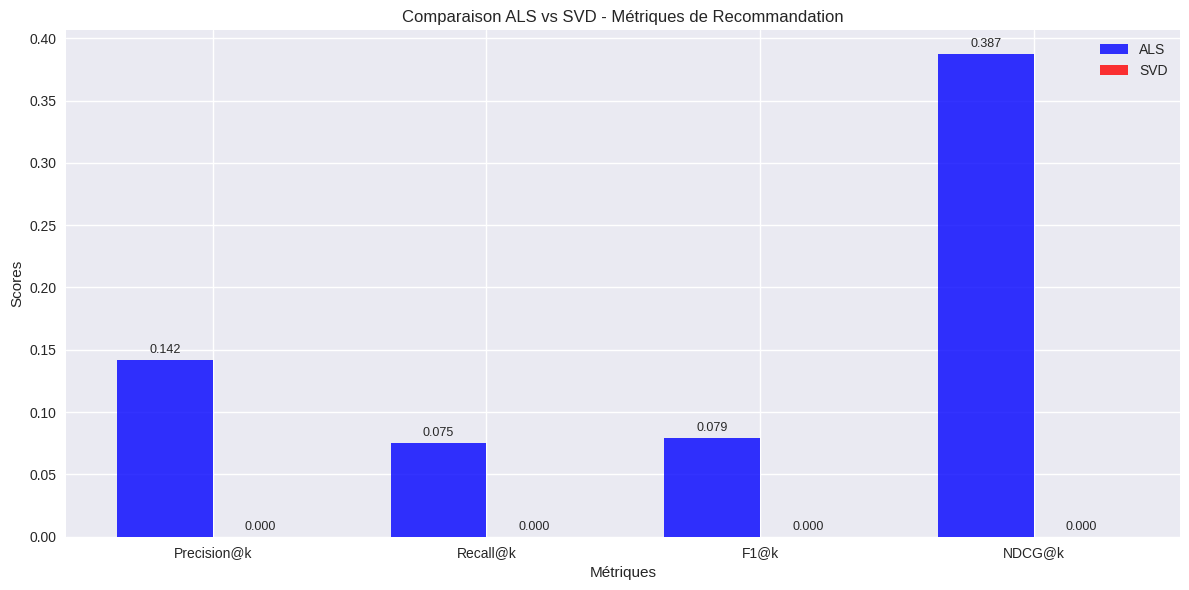

In [25]:
# Graphique de comparaison
metrics_names = ['Precision@k', 'Recall@k', 'F1@k', 'NDCG@k']
als_scores = [als_metrics[m] for m in metrics_names]
svd_scores = [svd_metrics[m] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6), facecolor='none')
bars1 = ax.bar(x - width/2, als_scores, width, label='ALS', alpha=0.8, color='blue')
bars2 = ax.bar(x + width/2, svd_scores, width, label='SVD', alpha=0.8, color='red')

ax.set_xlabel('Métriques')
ax.set_ylabel('Scores')
ax.set_title('Comparaison ALS vs SVD - Métriques de Recommandation')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()

# Ajouter les valeurs sur les barres
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Comparaison des Recommandations Dénormalisées

### Analyse Qualitative Côte à Côte

Cette section présente une comparaison directe et concrète des recommandations générées par les deux modèles :

- **Même utilisateur** : Application sur l'utilisateur 270 pour une comparaison équitable
- **Dénormalisation** : Conversion des prédictions en échelle 1-5 étoiles pour une interprétation intuitive
- **Statut des films** : Indication visuelle (✅ pour films déjà notés, 🆕 pour nouvelles suggestions)
- **Comparaison directe** : Affichage côte à côte des top-8 recommandations de chaque modèle

Cette analyse qualitative complète les métriques quantitatives en montrant concrètement ce que chaque modèle propose à un utilisateur réel, révélant les différences dans les préférences apprises et la diversité des recommandations.

In [28]:
def denormalize_svd_predictions(recommendations, scale):
    """Dénormalise les prédictions SVD"""
    min_rating, max_rating = scale
    denormalized_recs = []
    
    for item_id, pred, actual_rating in recommendations:
        denorm_pred = pred * (max_rating - min_rating) + min_rating
        denorm_actual = actual_rating * (max_rating - min_rating) + min_rating if actual_rating > 0 else None
        denormalized_recs.append((item_id, denorm_pred, denorm_actual))
    
    return denormalized_recs

def denormalize_als_predictions(recommendations, scale):
    """Dénormalise les prédictions ALS"""
    min_rating, max_rating = scale
    denormalized_recs = []
    
    for item_id, pred, actual_rating in recommendations:
        denorm_pred = pred * (max_rating - min_rating) + min_rating
        denorm_actual = actual_rating * (max_rating - min_rating) + min_rating if actual_rating > 0 else None
        denormalized_recs.append((item_id, denorm_pred, denorm_actual))
    
    return denormalized_recs

print(f"\nRECOMMANDATIONS DÉNORMALISÉES COMPARÉES:")
user_test_id = 3000

# ALS
als_recs = manual_model.recommend_for_user(user_test_id, n_recommendations=8, min_ratings=5, include_actual=True)
als_recs_denorm = denormalize_als_predictions(als_recs, scale)

# SVD
svd_recs = svd_wrapper.recommend_for_user(user_test_id, n_recommendations=8, min_ratings=5, include_actual=True)
svd_recs_denorm = denormalize_svd_predictions(svd_recs, scale)

print(f"\nALS Recommendations:")
for i, (item_id, pred, actual) in enumerate(als_recs_denorm):
    status = "✅" if actual is not None else "🆕"
    actual_str = f"{actual:.2f}" if actual is not None else "Non noté"
    print(f"   {i+1}. Item {item_id:4d} {status} Prédit: {pred:.2f} | Réel: {actual_str}")

print(f"\nSVD Recommendations:")
for i, (item_id, pred, actual) in enumerate(svd_recs_denorm):
    status = "✅" if actual is not None else "🆕"
    actual_str = f"{actual:.2f}" if actual is not None else "Non noté"
    print(f"   {i+1}. Item {item_id:4d} {status} Prédit: {pred:.2f} | Réel: {actual_str}")

print(f"\nCOMPARAISON TERMINÉE!")


RECOMMANDATIONS DÉNORMALISÉES COMPARÉES:

ALS Recommendations:
   1. Item   64 ✅ Prédit: 5.00 | Réel: 5.00
   2. Item  132 ✅ Prédit: 5.00 | Réel: 5.00
   3. Item  127 ✅ Prédit: 5.00 | Réel: 5.00
   4. Item  167 🆕 Prédit: 5.00 | Réel: Non noté
   5. Item  714 ✅ Prédit: 5.00 | Réel: 5.00
   6. Item   13 🆕 Prédit: 5.00 | Réel: Non noté
   7. Item  352 🆕 Prédit: 5.00 | Réel: Non noté
   8. Item  290 🆕 Prédit: 5.00 | Réel: Non noté

SVD Recommendations:
   1. Item 2905 🆕 Prédit: 4.26 | Réel: Non noté
   2. Item 3338 🆕 Prédit: 4.23 | Réel: Non noté
   3. Item 1117 🆕 Prédit: 4.22 | Réel: Non noté
   4. Item  318 🆕 Prédit: 4.19 | Réel: Non noté
   5. Item 2019 🆕 Prédit: 4.18 | Réel: Non noté
   6. Item 1148 ✅ Prédit: 4.18 | Réel: 3.00
   7. Item  745 🆕 Prédit: 4.17 | Réel: Non noté
   8. Item 2503 🆕 Prédit: 4.15 | Réel: Non noté

COMPARAISON TERMINÉE!
